# 비데/정수기 렌탈 고객 해지 여부 예측하기
- 과제 목표 : 렌탈 해지 예상 고객 예측, 해지 방지

In [713]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
from datetime import datetime, timedelta

np.random.seed(2023)


In [714]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.font_manager as fm
# # 설치되어 있는 폰트 확인하기
fm.get_font_names()

['Bell MT',
 'Microsoft JhengHei',
 'Bodoni MT',
 'cmsy10',
 'HYSinMyeongJo-Medium',
 'Parchment',
 'Segoe MDL2 Assets',
 'cmex10',
 'Gill Sans Ultra Bold Condensed',
 'Georgia',
 'Goudy Old Style',
 'Engravers MT',
 'Segoe UI',
 'Rockwell',
 'Webdings',
 'Footlight MT Light',
 'Poor Richard',
 'Bauhaus 93',
 'HCR Batang ExtB',
 'Kristen ITC',
 'MingLiU-ExtB',
 'Juice ITC',
 'Rockwell Condensed',
 'Forte',
 'Lucida Sans',
 'Headline R',
 'Colonna MT',
 'STIXSizeTwoSym',
 'Franklin Gothic Medium',
 'Onyx',
 'Segoe UI Variable',
 'Script MT Bold',
 'STIXSizeFiveSym',
 'Garamond',
 'Gill Sans Ultra Bold',
 'Informal Roman',
 'Segoe UI Symbol',
 'Tw Cen MT Condensed',
 'Gill Sans MT Condensed',
 'HyhwpEQ',
 'Brush Script MT',
 'Vladimir Script',
 'Niagara Solid',
 'Franklin Gothic Medium Cond',
 'Impact',
 'Baskerville Old Face',
 'Pyunji R',
 'Eras Demi ITC',
 'Book Antiqua',
 'HYPost-Light',
 'Constantia',
 'MT Extra',
 'Franklin Gothic Book',
 'Arial',
 'Berlin Sans FB',
 'Bookshelf Sym

In [715]:
import matplotlib
# NanumGothicCoding 폰트 설정하기
plt.rc('font',family = 'Malgun Gothic')

# 시각화할 때 음수 표시 설정하기
matplotlib.rcParams['axes.unicode_minus'] = False  

In [716]:
# 자동 완성 기능 설정하기
%config Completer.use_jedi = False

# 1. 기초 데이터 다루기/전처리

## 1-1. 데이터 획득하기

### 1) 데이터 파일 설명
- bidet_w_disp_termination_train/test.csv : 고객별 비데, 정수기 유지,해지 정보
- bidet_w_disp_voc_train/test.csv : 고객별 voc 발생건수

In [717]:
# 파일 읽어서 데이터프레임에 저장하기
train_termination = pd.read_csv('./데이터/bidet_w_disp_termination_train.csv')
test_termination = pd.read_csv('./데이터/bidet_w_disp_termination_test.csv')
train_voc = pd.read_csv('./데이터/bidet_w_disp_voc_train.csv')
test_voc = pd.read_csv('./데이터/bidet_w_disp_voc_test.csv')

## 1-2. 데이터 구조 확인

### 1) 데이터 설명
![Alt text](image-1.png)

### 2) info 함수를 활용하여 데이터프레임 정보 확인하기

In [718]:
# train_termination 데이터프레임의 기본적인 형태와 정보 확인하기
train_termination.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55000 entries, 0 to 54999
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    55000 non-null  object 
 1   status                55000 non-null  object 
 2   new_date              55000 non-null  int64  
 3   bidet_cnt             55000 non-null  int64  
 4   w_disp_cnt            54990 non-null  float64
 5   cust_cd               55000 non-null  int64  
 6   sex_cd                55000 non-null  object 
 7   w_disp_yn             55000 non-null  object 
 8   bidet_yn              55000 non-null  object 
 9   comb_prod_yn          55000 non-null  object 
 10  bidet_comb_yn         55000 non-null  object 
 11  w_disp_comb_yn        55000 non-null  object 
 12  bidet_trmn_eperd_cd   55000 non-null  object 
 13  w_disp_trmn_eperd_cd  55000 non-null  object 
 14  w_disp_trmn_why_cd    55000 non-null  object 
 15  bidet_trmn_why_cd  

In [719]:
# train_voc 데이터프레임의 기본적인 형태와 정보 확인하기
train_voc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74529 entries, 0 to 74528
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           74529 non-null  object
 1   voc_type_cd  74529 non-null  int64 
 2   voc_type_nm  74529 non-null  object
 3   voc_cnt      74529 non-null  int64 
 4   day_cnt      74529 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 2.8+ MB


### 3) head 메소드를 활용하여 데이터프레임 살펴보기

In [720]:
# 실제 데이터 확인하기
train_termination.head()

train_voc.head()

,id,voc_type_cd,voc_type_nm,voc_cnt,day_cnt
0,E1000001,6,청구 수/미납,1,1
1,E1000002,9,해지,1,1
2,E1000003,12,업무협조,1,1
3,E1000004,7,AS,1,1
4,E1000004,8,품질,1,1


## 1-3. 데이터프레임 합치기

### 1)피벗테이블(pivot_table)로 집계하기

In [721]:
# values: 계산 대상, aggfunc: 계산 유형, index: 행 인덱스, columns: 열 인덱스
train_voc_pivot = train_voc.pivot_table(values='voc_cnt', aggfunc='sum', 
                                        index='id', columns='voc_type_nm', 
                                        fill_value=0 # 값이 존재하지 않는 셀을 채울지(default = NaN)
                                        )

train_voc_pivot 

voc_type_nm,AS,가입,개통,대리점문의,변경/조회,업무협조,이용,정보보호/언론보도,채널,청구 수/미납,품질,해지,혜택
id,,,,,,,,,,,,,
E1000001,0,0,0,0,0,0,0,0,0,1,0,0,0
E1000002,0,0,0,0,0,0,0,0,0,0,0,1,0
E1000003,0,0,0,0,0,1,0,0,0,0,0,0,0
E1000004,1,0,0,0,0,0,0,0,0,0,1,0,0
E1000005,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
E1054996,0,0,0,0,0,0,0,0,0,0,1,0,0
E1054997,0,0,0,0,0,0,0,0,0,0,0,1,0
E1054998,0,0,0,0,0,2,0,0,0,0,0,0,0


In [722]:
# VOC건수(voc_cnt)별, VOC발생일수(day_cnt)별, train/test 각각 피벗테이블 생성하기
train_voc_cnt = train_voc.pivot_table(values='voc_cnt',aggfunc='sum',
                                      index='id', columns='voc_type_nm', fill_value=0)

train_day_cnt = train_voc.pivot_table(values='day_cnt',aggfunc='sum',
                                      index='id',columns='voc_type_nm',fill_value=0)

test_voc_cnt = test_voc.pivot_table(values='voc_cnt',aggfunc='sum',
                                    index='id',columns='voc_type_nm',fill_value=0)

test_day_cnt = test_voc.pivot_table(values='day_cnt',aggfunc='sum',
                                    index='id',columns='voc_type_nm',fill_value=0)

In [723]:
# pivot_table로 집계 전 VOC건수 확인하여 검증하기
train_voc['voc_cnt'].sum(), train_voc['day_cnt'].sum(), test_voc['voc_cnt'].sum(), test_voc['day_cnt'].sum()

(90752, 82858, 8469, 7702)

In [724]:
train_voc_cnt.sum()

voc_type_nm
AS            2398
가입            7146
개통            1072
대리점문의            2
변경/조회        11807
업무협조         18285
이용            6823
정보보호/언론보도      355
채널            4694
청구 수/미납      12775
품질            6490
해지           16894
혜택            2011
dtype: int64

In [725]:
# pivot_table로 집계 후 VOC건수 확인하여 검증하기
train_voc_cnt.sum().sum(), train_day_cnt.sum().sum(), test_voc_cnt.sum().sum(), test_day_cnt.sum().sum()

(90752, 82858, 8469, 7702)

### 2)데이터프레임 병합하기

In [726]:
# 인덱스인 id의 순서를 동일하게 맞춰주고 drop해준다.
train_voc_cnt = train_voc_cnt.reset_index(drop=True)
train_day_cnt = train_day_cnt.reset_index(drop=True)
test_voc_cnt = test_voc_cnt.reset_index(drop=True)
test_day_cnt = test_day_cnt.reset_index(drop=True)

In [727]:
# 결과 확인
train_voc_cnt

voc_type_nm,AS,가입,개통,대리점문의,변경/조회,업무협조,이용,정보보호/언론보도,채널,청구 수/미납,품질,해지,혜택
0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54995,0,0,0,0,0,0,0,0,0,0,1,0,0
54996,0,0,0,0,0,0,0,0,0,0,0,1,0
54997,0,0,0,0,0,2,0,0,0,0,0,0,0
54998,0,0,0,0,0,0,0,0,0,1,0,1,0


In [728]:
# 결과 확인
train_day_cnt

voc_type_nm,AS,가입,개통,대리점문의,변경/조회,업무협조,이용,정보보호/언론보도,채널,청구 수/미납,품질,해지,혜택
0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54995,0,0,0,0,0,0,0,0,0,0,1,0,0
54996,0,0,0,0,0,0,0,0,0,0,0,1,0
54997,0,0,0,0,0,1,0,0,0,0,0,0,0
54998,0,0,0,0,0,0,0,0,0,1,0,1,0


In [729]:
# 데이터프레임을 합쳤을 때 칼럼명이 중복되지 않도록 변경하기(prefix 붙이기)
for col in train_voc_cnt.columns:
    train_day_cnt.rename(columns={col:'day_cnt_'+col}, inplace=True)
    train_voc_cnt.rename(columns={col:'voc_cnt_'+col}, inplace=True)

for col in test_voc_cnt.columns:
    test_voc_cnt.rename(columns={col:'voc_cnt_'+col},inplace=True)
    test_day_cnt.rename(columns={col:'day_cnt_'+col},inplace=True)

In [730]:
train_termination.head()

,id,status,new_date,bidet_cnt,w_disp_cnt,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,bidet_comb_yn,w_disp_comb_yn,bidet_trmn_eperd_cd,w_disp_trmn_eperd_cd,w_disp_trmn_why_cd,bidet_trmn_why_cd,npay_yn,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,w_disp_engt_rperd_cd,bidet_engt_rperd_cd
0,E1000001,Y,20170421,1,0.0,10001,F,Y,Y,Y,Y,Y,_,_,_,_,Y,381711.000,40393,43560,R09,R12
1,E1000002,N,20131203,2,0.0,10001,M,N,Y,N,N,N,_,_,_,_,N,110100.000,34460,0,_,R06
2,E1000003,N,20170731,1,1.0,10001,M,Y,N,Y,Y,Y,_,_,_,_,N,90000.000,0,28600,0,_
3,E1000004,Y,20090930,4,1.0,10001,F,Y,Y,Y,Y,Y,_,_,_,_,Y,218303.001,34747,55000,P36,R11
4,E1000005,N,20151121,1,1.0,10001,F,Y,Y,Y,Y,Y,_,_,_,_,N,310095.999,59856,54082,R27,R22


In [731]:
train_voc_cnt.head()

voc_type_nm,voc_cnt_AS,voc_cnt_가입,voc_cnt_개통,voc_cnt_대리점문의,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_정보보호/언론보도,voc_cnt_채널,voc_cnt_청구 수/미납,voc_cnt_품질,voc_cnt_해지,voc_cnt_혜택
0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0


In [732]:
train_day_cnt.head()

voc_type_nm,day_cnt_AS,day_cnt_가입,day_cnt_개통,day_cnt_대리점문의,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_정보보호/언론보도,day_cnt_채널,day_cnt_청구 수/미납,day_cnt_품질,day_cnt_해지,day_cnt_혜택
0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0


In [733]:
# pd.concat([병합 대상 list], axis=1) 
train_data=pd.concat([train_termination,train_voc_cnt,train_day_cnt],axis=1)
test_data=pd.concat([test_termination,test_voc_cnt,test_day_cnt],axis=1)

# 결과 확인
train_data.shape,  test_data.shape

((55000, 48), (5000, 46))

In [734]:
# train_data의 칼럼중에서 test_data에 없는 칼럼 찾기
[x for x in train_data.columns.tolist() if x not in test_data.columns.tolist()]

['voc_cnt_대리점문의', 'day_cnt_대리점문의']

In [735]:
# train_data에만 존재하는 2개 칼럼 삭제하기
train_data.drop(['voc_cnt_대리점문의','day_cnt_대리점문의'],axis=1,inplace=True)

# 삭제 후 결과 확인하기
train_data.shape, test_data.shape

((55000, 46), (5000, 46))

## 1-4. 결측치 처리하기

### 1)결측치 확인하기

In [736]:
train_data.isnull().sum() # w_disp_cnt : 10개
train_data.isnull().sum().sum() # 10개
# test_data.isnull().sum()
# test_data.isnull().sum().sum()  # 0개

10

In [737]:
train_data[train_data['w_disp_cnt'].isnull()]
# 정수기 계약 수가 모두 빈칸

,id,status,new_date,bidet_cnt,w_disp_cnt,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,bidet_comb_yn,w_disp_comb_yn,bidet_trmn_eperd_cd,w_disp_trmn_eperd_cd,w_disp_trmn_why_cd,bidet_trmn_why_cd,npay_yn,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,w_disp_engt_rperd_cd,bidet_engt_rperd_cd,voc_cnt_AS,voc_cnt_가입,voc_cnt_개통,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_정보보호/언론보도,voc_cnt_채널,voc_cnt_청구 수/미납,voc_cnt_품질,voc_cnt_해지,voc_cnt_혜택,day_cnt_AS,day_cnt_가입,day_cnt_개통,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_정보보호/언론보도,day_cnt_채널,day_cnt_청구 수/미납,day_cnt_품질,day_cnt_해지,day_cnt_혜택
50,E1000051,Y,20200515,0,NaN,10001,F,Y,Y,Y,Y,Y,_,_,_,_,N,177563.001,29793,74708,R34,P05,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
51,E1000052,N,20150416,0,NaN,10001,F,Y,Y,Y,Y,Y,_,_,_,_,N,83873.001,16792,38106,P27,R11,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0
52,E1000053,N,20121022,1,NaN,10001,M,N,Y,N,N,N,_,_,_,_,N,50318.001,16772,0,_,R01,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
53,E1000054,N,20160210,2,NaN,10001,F,N,Y,N,N,N,_,_,_,_,N,7809.000,2603,0,_,P23,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0
54,E1000055,N,20161028,1,NaN,10001,M,N,Y,N,N,N,_,_,_,_,Y,12582.000,4124,0,_,P15,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
55,E1000056,Y,20130515,3,NaN,10001,M,Y,Y,Y,Y,Y,_,_,_,_,N,318153.999,35497,32666,P34,R11,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
56,E1000057,Y,20200716,1,NaN,10001,F,Y,Y,Y,Y,Y,_,_,_,_,Y,400389.000,32356,54992,R21,R09,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
57,E1000058,Y,20190209,5,NaN,10001,M,Y,Y,Y,Y,Y,_,_,_,_,N,337518.000,46443,46200,R19,R13,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
58,E1000059,N,20171023,2,NaN,10001,F,N,Y,Y,Y,Y,_,_,_,_,N,98709.000,32540,0,_,P03,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
59,E1000060,Y,20180927,1,NaN,10001,M,Y,Y,Y,Y,Y,_,_,_,_,N,367350.000,33403,50600,R14,R08,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


### 2)결측치 대체하기

In [738]:
# 평균값(mean), 중위값(median), 최빈값(mode) 확인하기
print("평균값:",train_data['w_disp_cnt'].mean())
print("중위값:",train_data['w_disp_cnt'].median())
print("최빈값:",train_data['w_disp_cnt'].mode())

평균값: 0.7372067648663393
중위값: 1.0
최빈값: 0    1.0
Name: w_disp_cnt, dtype: float64


디스트플롯(Distplot)
- 히스토그램 + 커널 밀도 추정 그래프(kdeplot)
- 분포 + 밀도 함께 확인 가능

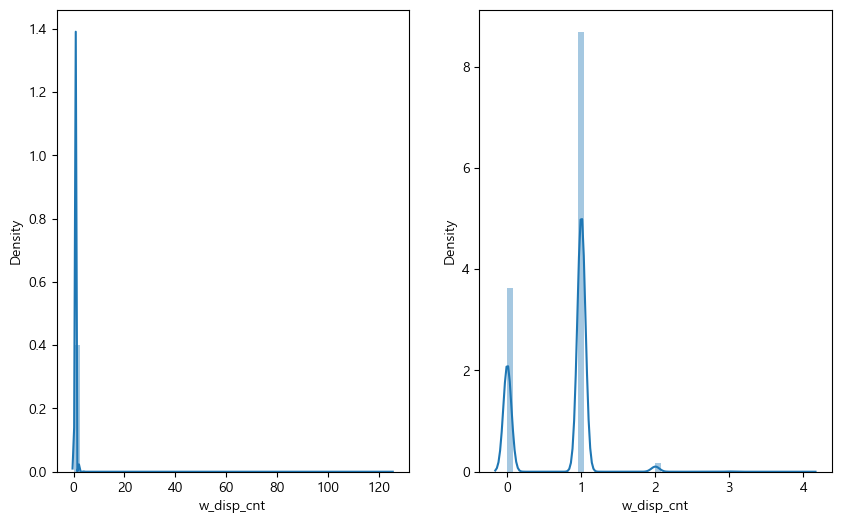

In [739]:
# 그래프의 크기, 옵션 지정하기
fig, ax = plt.subplots(ncols=2, figsize = (10,6))

# distplot 생성
sns.distplot(train_data['w_disp_cnt'], ax=ax[0])

# 10이하로 몰려있는 수치를 잘 보기 위해서
# sns.distplot(train_data[train_data['w_disp_cnt']<10]['w_disp_cnt'], ax=ax[1])
sns.distplot(train_data[train_data['w_disp_cnt']<5]['w_disp_cnt'], ax=ax[1])

plt.show()

In [740]:
# df.fillna("대체값", inplace=True)
train_data['w_disp_cnt'].fillna(train_data['w_disp_cnt'].median(), inplace=True)

# 결측치 제거 결과 확인하기
train_data.isnull().sum().sum(),   test_data.isnull().sum().sum()

(0, 0)

## 1-5. 데이터 유형 변경하기

In [741]:
train_data.info()

# --> new_date와 cust_cd는 각각 날짜, object로 바꿔야하는데, 그렇지 않음..

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55000 entries, 0 to 54999
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    55000 non-null  object 
 1   status                55000 non-null  object 
 2   new_date              55000 non-null  int64  
 3   bidet_cnt             55000 non-null  int64  
 4   w_disp_cnt            55000 non-null  float64
 5   cust_cd               55000 non-null  int64  
 6   sex_cd                55000 non-null  object 
 7   w_disp_yn             55000 non-null  object 
 8   bidet_yn              55000 non-null  object 
 9   comb_prod_yn          55000 non-null  object 
 10  bidet_comb_yn         55000 non-null  object 
 11  w_disp_comb_yn        55000 non-null  object 
 12  bidet_trmn_eperd_cd   55000 non-null  object 
 13  w_disp_trmn_eperd_cd  55000 non-null  object 
 14  w_disp_trmn_why_cd    55000 non-null  object 
 15  bidet_trmn_why_cd  

In [742]:
# 실제와 데이터 유형이 다른 칼럼 확인하기
train_data.loc[:5,['new_date','cust_cd']]

,new_date,cust_cd
0,20170421,10001
1,20131203,10001
2,20170731,10001
3,20090930,10001
4,20151121,10001
5,20120711,10001


int → datetime

In [743]:
# # 1 번째 방법
# 날짜형식으로 변경하기(y/m/d)
# train_data['new_date'] = pd.to_datetime(train_data['new_date'], format='%Y%m%d')
# test_data['new_date'] = pd.to_datetime(test_data['new_date'], format='%Y%m%d')
# train_data['new_date'].head()

# # 2번째 방법
def GetDateTime(date):
    date = datetime.strptime(str(date), '%Y%m%d')
    return date

train_data['new_date'] = train_data['new_date'].apply(lambda x : GetDateTime(x))
test_data['new_date'] = test_data['new_date'].apply(lambda x : GetDateTime(x))

print('변경 후 타입 : ', test_data['new_date'].dtype)

변경 후 타입 :  datetime64[ns]


int → object

In [744]:
# 고객 코드 -> 범주형 확인
train_data['cust_cd'].value_counts()

# object로 변경하기
train_data['cust_cd'] = train_data['cust_cd'].astype('O')
test_data['cust_cd'] = test_data['cust_cd'].astype('O')

# 확인
print('train 타입 :', train_data['cust_cd'].dtype)
print('test 타입 :', test_data['cust_cd'].dtype)

train 타입 : object
test 타입 : object


## 1-6. 파생 변수 추가
- 업무 담당자의 도메인 지식이 빛을 발하는 부분이다. 
- 이후 데이터 분석이나 AI 모델링에 큰 영향을 줄 수 있다.
---
- 날짜
    - 시간의 흐름에 의미가 있는 데이터이다.
    - 실제 운영 환경에서는 학습 시점과 예측하는 시점이 다르다. 
    - 따라서 데이터의 추출 시점이 다르기 때문에 동일한 날짜라도 x개월 경과한 시점과 y개월 경과한 시점에 날짜의 의미가 다르다.  

### 1)날짜데이터 -> 경과시간 데이터로 파생 변수 만들기

In [745]:
print(train_data['new_date'].max())
print(test_data['new_date'].max())

2020-08-31 00:00:00
2020-09-30 00:00:00


train_data : ~ 20/ 8/ 31 까지
test_data : ~ 20/ 9/ 30 까지

1개월의 시점 차이가 발생함
-> 기준점을 각각 8.31, 9.30로 잡고 가입기간을 산정하여 대체한다.

In [746]:
# datetime까지 뺄셈, 덧셈이 가능
# days는 timedelta64형이므로 가입기간을 int형으로 변경하는 작업이 필요함
# (.dt.days붙임)하여 int로 바꾸고 파생 변수 추가하기

train_data['join_period'] = (datetime(2020,8,31,0,0) - train_data['new_date']).dt.days
test_data['join_period'] = (datetime(2020,9,30,0,0) - test_data['new_date']).dt.days

train_data['join_period'].head()

0    1228
1    2463
2    1127
3    3988
4    1745
Name: join_period, dtype: int64

### 2)해지 경과 기간 코드(trmn_eperd_cd)을 이용하여 파생 변수 추가하기
- 특정 상품의 해지가 발생하면, 고객이 보유한 다른 상품도 해지할 가능성이 있다.
- 장기 미납자에 대한 해지 처리나 결합으로 묶여 있던 상품이 타사로 일괄 이동하는 경우가 있다.

In [747]:
# 대상 칼럼들
teperd_cols = ['w_disp_trmn_eperd_cd', 'bidet_trmn_eperd_cd']

# 대상 칼럼들 실제 데이터 확인
train_data[teperd_cols]
 # 상품 해지 경과 기간 코드 R37...

,w_disp_trmn_eperd_cd,bidet_trmn_eperd_cd
0,_,_
1,_,_
2,_,_
3,_,_
4,_,_
...,...,...
54995,_,_
54996,_,R37
54997,_,_
54998,_,_


In [748]:
# train_data['w_disp_trmn_eperd_cd'].value_counts()
train_data['bidet_trmn_eperd_cd'].value_counts()

# 당월 : 0
# 해지 후 경과 기간은 R뒤 두자리 수로 표현
# 해지 하지 않은 경우 : _

_      50971
R37     1697
0        412
R01      141
R02      106
R08       91
R04       91
R11       87
R03       80
R07       78
R12       74
R05       71
R09       65
R06       61
R10       56
R31       51
R18       51
R23       47
R32       47
R19       47
R14       45
R13       45
R20       44
R16       40
R24       39
R25       38
R33       38
R15       38
R36       37
R35       36
R17       35
R26       34
R21       34
R30       33
R34       33
R22       33
R28       30
R27       23
R29       21
Name: bidet_trmn_eperd_cd, dtype: int64

In [749]:
def IntTermination(Rcd):
    if Rcd == '0':
        return 0
    elif Rcd == '_':
        return 38
    else:
        return int(Rcd[1:3])
        
        
# teperd_cols = ['w_disp_trmn_eperd_cd', 'bidet_trmn_eperd_cd']
for column in teperd_cols:
    new_column=column.replace('_trmn_eperd_cd','_teperd')
    train_data[new_column]=train_data[column].apply(lambda x: IntTermination(x))
    test_data[new_column]=test_data[column].apply(lambda x: IntTermination(x))

train_data.iloc[:,-2:]

,w_disp_teperd,bidet_teperd
0,38,38
1,38,38
2,38,38
3,38,38
4,38,38
...,...,...
54995,38,38
54996,38,37
54997,38,38
54998,38,38


### 3)약정잔여기간코드(engt_rperd_cd) 관련 파생 변수 추가하기

In [750]:
# 대상 칼럼 리스트 지정
erperd_cols=['w_disp_engt_rperd_cd', 'bidet_engt_rperd_cd']

# 실제값 확인
train_data.loc[:,erperd_cols].head() 

,w_disp_engt_rperd_cd,bidet_engt_rperd_cd
0,R09,R12
1,_,R06
2,0,_
3,P36,R11
4,R27,R22


In [751]:
# 분호 확인
train_data['bidet_trmn_eperd_cd'].value_counts()

# 범주값 확인하기
train_data['bidet_engt_rperd_cd'].value_counts().index

Index(['_', 'R12', 'R07', 'R06', 'R11', 'R10', 'R09', 'R13', 'R24', 'R08',
       'R23', 'R14', 'R22', 'R05', 'R15', 'R04', 'R21', 'R02', 'R01', 'R30',
       'R20', 'R18', 'R16', 'R03', 'R19', 'R29', 'R17', '0', 'R28', 'R25',
       'P37', 'R26', 'R27', 'P01', '|', 'P02', 'P04', 'P06', 'P03', 'P07',
       'P05', 'P08', 'P09', 'P11', 'P12', 'P10', 'P15', 'P14', 'P13', 'P16',
       'P18', 'P19', 'P22', 'P20', 'P21', 'P17', 'P24', 'P23', 'P26', 'P25',
       'P28', 'P31', 'P32', 'P27', 'P30', 'P29', 'P33', 'P35', 'P36', 'P34',
       'R34'],
      dtype='object')

- 무약정 : _ -> 38로 처리
- 이미 해지됨 : | -> 38로 처리
- 약정 만료 후 기간 : P -> 양수로 처리
- 잔여 약정 기간 : R -> 음수로 처리
- 당월 약정 만료 : 0 

In [752]:
def RemaindPriod(cd):
    if (cd == '_') | (cd == '|'):
        return 38
    elif cd == '0':
        return 0
    elif cd[0] == 'P':
        return int(cd[1:3])
    else: # 잔여 약정
        return -int(cd[1:3])
        
        
# erperd_cols=['w_disp_engt_rperd_cd', 'bidet_engt_rperd_cd']
for column in erperd_cols:
    new_column=column.replace('_engt_rperd_cd','_erperd')
    train_data[new_column]=train_data[column].apply(lambda x: RemaindPriod(x))
    test_data[new_column]=test_data[column].apply(lambda x: RemaindPriod(x))

train_data.iloc[:,-2:]

,w_disp_erperd,bidet_erperd
0,-9,-12
1,38,-6
2,0,38
3,36,-11
4,-27,-22
...,...,...
54995,32,38
54996,1,38
54997,38,-18
54998,38,-19


In [753]:
train_data

,id,status,new_date,bidet_cnt,w_disp_cnt,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,bidet_comb_yn,w_disp_comb_yn,bidet_trmn_eperd_cd,w_disp_trmn_eperd_cd,w_disp_trmn_why_cd,bidet_trmn_why_cd,npay_yn,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,w_disp_engt_rperd_cd,bidet_engt_rperd_cd,voc_cnt_AS,voc_cnt_가입,voc_cnt_개통,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_정보보호/언론보도,voc_cnt_채널,voc_cnt_청구 수/미납,voc_cnt_품질,voc_cnt_해지,voc_cnt_혜택,day_cnt_AS,day_cnt_가입,day_cnt_개통,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_정보보호/언론보도,day_cnt_채널,day_cnt_청구 수/미납,day_cnt_품질,day_cnt_해지,day_cnt_혜택,join_period,w_disp_teperd,bidet_teperd,w_disp_erperd,bidet_erperd
0,E1000001,Y,2017-04-21,1,0.0,10001,F,Y,Y,Y,Y,Y,_,_,_,_,Y,381711.000,40393,43560,R09,R12,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1228,38,38,-9,-12
1,E1000002,N,2013-12-03,2,0.0,10001,M,N,Y,N,N,N,_,_,_,_,N,110100.000,34460,0,_,R06,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,2463,38,38,38,-6
2,E1000003,N,2017-07-31,1,1.0,10001,M,Y,N,Y,Y,Y,_,_,_,_,N,90000.000,0,28600,0,_,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1127,38,38,0,38
3,E1000004,Y,2009-09-30,4,1.0,10001,F,Y,Y,Y,Y,Y,_,_,_,_,Y,218303.001,34747,55000,P36,R11,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,3988,38,38,36,-11
4,E1000005,N,2015-11-21,1,1.0,10001,F,Y,Y,Y,Y,Y,_,_,_,_,N,310095.999,59856,54082,R27,R22,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1745,38,38,-27,-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54995,E1054996,N,2005-09-16,0,1.0,10001,M,Y,N,Y,N,Y,_,_,_,_,Y,127844.001,0,44800,P32,_,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5463,38,38,32,38
54996,E1054997,Y,2013-01-17,0,1.0,10001,F,Y,N,Y,N,Y,R37,_,_,10291,N,99000.000,0,48400,P01,_,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,2783,38,37,1,38
54997,E1054998,Y,2019-07-09,4,1.0,10001,F,N,Y,N,N,N,_,_,_,_,N,77882.001,14759,0,_,R18,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,419,38,38,38,-18
54998,E1054999,Y,2019-08-12,3,1.0,10001,M,N,Y,N,N,N,_,_,_,_,N,114221.001,15031,0,_,R19,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,385,38,38,38,-19


In [754]:
train_data['id'].value_counts() # 1:1
del_cols = ['id']

## 1-7. 불필요한 칼럼 삭제하기
- 파생 변수를 추가하면서 불필요하게 된 칼럼
- 단일값이거나 지나치게 데이터가 불균형한 칼럼 -> 과대적합 발생 시키는 원인

In [755]:
# 수치형 데이터 칼럼 담기
num_cols = train_data.select_dtypes(['int64', 'float64']).columns
num_cols

# 범주형 데이터 칼럼 담기
obj_cols = train_data.select_dtypes(['O']).columns
obj_cols

Index(['id', 'status', 'cust_cd', 'sex_cd', 'w_disp_yn', 'bidet_yn',
       'comb_prod_yn', 'bidet_comb_yn', 'w_disp_comb_yn',
       'bidet_trmn_eperd_cd', 'w_disp_trmn_eperd_cd', 'w_disp_trmn_why_cd',
       'bidet_trmn_why_cd', 'npay_yn', 'w_disp_engt_rperd_cd',
       'bidet_engt_rperd_cd'],
      dtype='object')

In [756]:
train_data.loc[:, num_cols].describe()

# 0의 비중이 많으므로 0이 데이터의 90% 이상인 칼럼을 삭제 대상으로 지정한다.

,bidet_cnt,w_disp_cnt,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,voc_cnt_AS,voc_cnt_가입,voc_cnt_개통,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_정보보호/언론보도,voc_cnt_채널,voc_cnt_청구 수/미납,voc_cnt_품질,voc_cnt_해지,voc_cnt_혜택,day_cnt_AS,day_cnt_가입,day_cnt_개통,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_정보보호/언론보도,day_cnt_채널,day_cnt_청구 수/미납,day_cnt_품질,day_cnt_해지,day_cnt_혜택,join_period,w_disp_teperd,bidet_teperd,w_disp_erperd,bidet_erperd
count,55000.000000,55000.000000,5.500000e+04,5.500000e+04,5.500000e+04,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000
mean,2.596782,0.737255,2.915999e+05,3.441105e+04,4.162946e+04,0.043600,0.129927,0.019491,0.214673,0.332455,0.124055,0.006455,0.085345,0.232273,0.118000,0.307164,0.036564,0.038400,0.125909,0.018055,0.201436,0.284218,0.117691,0.006382,0.075455,0.219764,0.110327,0.272909,0.035927,1858.126418,36.910036,36.868073,14.631273,-0.475927
std,66.479010,1.137088,8.496803e+05,3.833091e+04,3.965128e+05,0.256391,0.366102,0.166522,0.552657,0.885980,0.398879,0.082541,0.387991,0.510258,0.390811,0.621277,0.209654,0.212215,0.348169,0.149002,0.447934,0.580211,0.362700,0.080765,0.316198,0.464854,0.351533,0.518703,0.204719,1616.054444,5.627786,5.708939,26.576813,22.398369
min,0.000000,0.000000,-1.136300e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-37.000000,-34.000000
25%,1.000000,0.000000,1.102485e+05,1.131050e+04,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,748.000000,38.000000,38.000000,-9.000000,-15.000000
50%,1.000000,1.000000,1.994620e+05,3.107550e+04,3.266000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1357.000000,38.000000,38.000000,34.000000,-8.000000
75%,2.000000,1.000000,3.363403e+05,4.804125e+04,4.791800e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2517.000000,38.000000,38.000000,38.000000,10.000000
max,5077.000000,125.000000,1.806220e+08,3.092769e+06,6.078027e+07,7.000000,6.000000,5.000000,59.000000,102.000000,14.000000,3.000000,12.000000,9.000000,11.000000,8.000000,6.000000,5.000000,4.000000,5.000000,11.000000,16.000000,11.000000,2.000000,9.000000,7.000000,7.000000,6.000000,6.000000,8396.000000,38.000000,38.000000,38.000000,38.000000


### 1)동일값이 90%이상 차지하는 경우 

In [757]:
# 0이 90%이상인 칼럼 삭제 대상에 추가하기
for col in num_cols:
    if(((train_data[col]==0).sum() / 55000) > 0.9):
        print(col + " : " + str((train_data[col]==0).sum() / 55000))
        del_cols.append(col)

voc_cnt_AS : 0.9651272727272727
voc_cnt_개통 : 0.9838181818181818
voc_cnt_정보보호/언론보도 : 0.9937090909090909
voc_cnt_채널 : 0.9343090909090909
voc_cnt_품질 : 0.9000363636363636
voc_cnt_혜택 : 0.9671818181818181
day_cnt_AS : 0.9651272727272727
day_cnt_개통 : 0.9838181818181818
day_cnt_정보보호/언론보도 : 0.9937090909090909
day_cnt_채널 : 0.9343090909090909
day_cnt_품질 : 0.9000363636363636
day_cnt_혜택 : 0.9671818181818181


In [758]:
train_data.loc[:, obj_cols].describe()

# 0의 비중이 많으므로 0이 데이터의 90% 이상인 칼럼을 삭제 대상으로 지정한다.

,id,status,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,bidet_comb_yn,w_disp_comb_yn,bidet_trmn_eperd_cd,w_disp_trmn_eperd_cd,w_disp_trmn_why_cd,bidet_trmn_why_cd,npay_yn,w_disp_engt_rperd_cd,bidet_engt_rperd_cd
count,55000,55000,55000,55000,55000,55000,55000,55000,55000,55000,55000,55000,55000,55000,55000,55000
unique,55000,2,2,3,2,2,2,2,2,39,39,94,31,2,77,71
top,E1000001,Y,10001,M,Y,Y,Y,Y,Y,_,_,_,_,N,_,_
freq,1,31806,53681,28486,32474,44657,41462,33075,38924,50971,51578,51812,51119,44920,22924,10996


In [759]:
# 범주형 칼럼(obj_cols)에 대해 가장 많은 범주의 비중이 90%를 넘는 칼럼 찾기

for column in obj_cols:
    
    # value_count() 반환할 때 가장 빈도가 많은 값부터 내림차순으로 반환하는 것을 이용한다
    if((train_data[column].value_counts().iloc[0]/55000) >0.9):        
        print(column+':'+str(train_data[column].value_counts().iloc[0]/55000))
        del_cols.append(column)  # del_cols에 해당 칼럼 추가하기

cust_cd:0.9760181818181818
bidet_trmn_eperd_cd:0.9267454545454545
w_disp_trmn_eperd_cd:0.9377818181818182
w_disp_trmn_why_cd:0.9420363636363637
bidet_trmn_why_cd:0.9294363636363636


### 2)파생 변수로 대체한 칼럼

In [760]:
temp = ['new_date','w_disp_engt_rperd_cd', 'bidet_engt_rperd_cd', 'bidet_trmn_eperd_cd', 'w_disp_trmn_eperd_cd']

del_cols.extend(temp)

In [761]:
list(set(del_cols))

['bidet_trmn_eperd_cd',
 'voc_cnt_품질',
 'id',
 'day_cnt_정보보호/언론보도',
 'w_disp_trmn_why_cd',
 'day_cnt_채널',
 'w_disp_trmn_eperd_cd',
 'voc_cnt_혜택',
 'day_cnt_AS',
 'new_date',
 'voc_cnt_개통',
 'cust_cd',
 'w_disp_engt_rperd_cd',
 'voc_cnt_AS',
 'day_cnt_품질',
 'day_cnt_개통',
 'bidet_trmn_why_cd',
 'voc_cnt_채널',
 'day_cnt_혜택',
 'bidet_engt_rperd_cd',
 'voc_cnt_정보보호/언론보도']

### 3)삭제 대상 칼럼들 일괄 삭제하기

In [762]:
# 삭제 대상 칼럼을 train_data와 test_data에서 삭제하기
train_data.drop(del_cols, axis=1, inplace=True)
test_data.drop(del_cols, axis=1, inplace=True)
train_data.info() # 결과 확인하기

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55000 entries, 0 to 54999
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   status             55000 non-null  object 
 1   bidet_cnt          55000 non-null  int64  
 2   w_disp_cnt         55000 non-null  float64
 3   sex_cd             55000 non-null  object 
 4   w_disp_yn          55000 non-null  object 
 5   bidet_yn           55000 non-null  object 
 6   comb_prod_yn       55000 non-null  object 
 7   bidet_comb_yn      55000 non-null  object 
 8   w_disp_comb_yn     55000 non-null  object 
 9   npay_yn            55000 non-null  object 
 10  3m_avg_bill_amt    55000 non-null  float64
 11  3m_bidet_avg_amt   55000 non-null  int64  
 12  3m_w_disp_avg_amt  55000 non-null  int64  
 13  voc_cnt_가입         55000 non-null  int64  
 14  voc_cnt_변경/조회      55000 non-null  int64  
 15  voc_cnt_업무협조       55000 non-null  int64  
 16  voc_cnt_이용         550